<a href="https://colab.research.google.com/github/josephasal/cosmo_inference/blob/main/mcmc/tuning_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Running all the other notebooks to load them in
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Restructured code/mcmc_functions.ipynb'

#loading in the data from google drive, cleaning and assigning variables
filepath = '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Restructured code/LOWZ+ESSENCE+SNLS.csv'
supernova_df = pd.read_csv(filepath)

#defining variables
redshift = supernova_df['Z']
distance_mod = supernova_df['MU']
err_distance_mod = supernova_df['MUERR']

# Adaptive sampling pilot runs for parameter tuning
Need to find the 'best' parameters for my adaptive sampling algorithm.
Ok so last time i did this really inefficiently, doing it a different way this time.

Going to vary the intial step sizes, update intervals, learning rates and measure the acceptance rate, effective sample size (and also check they converge)

Then once a few good ones have been found i will further look into them by looking at the covariance and step history, which i have added to my adaptive mcmc function already

In [2]:
#Define the parameters i want to experiment with
intial_step_sizes = [[0.01, 0.01], [0.02, 0.02], [0.05, 0.05]]  # 3 moderately close step sizes at first
update_intervals = [100, 200, 300] #if you dont know what this is its after how many steps does the adaptive sampling algorithm change the covariance matrix
learning_rates = [0.01, 0.05, 0.1]

#Use itertools to make a grid of combinations
from itertools import product

parameter_grid = list(product(intial_step_sizes, update_intervals, learning_rates))
print('Combinations:', len(parameter_grid)) #the number of different runs is how many different combos there are. Combo made me think of zinmger box meal yummy im hungry




Combinations: 27


In [3]:
%%time


results = [] #empty array to store innit

#Running Adaptive MCMC on all the different combos

#things we keeping fixed
n_steps = 2000
burn_in = 0.2
n_walkers = 10
target_alpha = 0.2
n_walkers = 10

#loop for all values
for (step_size, update_intervals, learning_rates) in parameter_grid:

  #10 initial guesses in the ranges of 0.2<omega_m<0.4 and 0.6<h<0.8
  initial_guess = [[np.random.uniform(0.2,0.4), np.random.uniform(0.6,0.8)]
                for _ in range(n_walkers)]
  #calling the adaptive mcmc function
  samples, avg_alpha, cov_hist, step_hist = adaptive_metropolis_hastings(log_likelihood,
                                                                         redshift,
                                                                         distance_mod,
                                                                         err_distance_mod,
                                                                         n_steps,
                                                                         initial_guess, step_size,
                                                                         burn_in, n_walkers, update_intervals, target_alpha, learning_rates)


  #Calculate ess for the combination we are on for both omega m and h, using the ess function defined in the convergence diagnostics file
  ess_omega = eff_sample_size_multichain(samples[:,:,0])
  ess_h = eff_sample_size_multichain(samples[:,:,1])

  #store all of this shit in a dictionary
  results.append({ 'samples': samples,
      'step_size': step_size, 'update_interval': update_intervals,
      'learning_rate': learning_rates, 'avg_alpha': avg_alpha,
    'ess_omega': ess_omega, 'ess_h': ess_h, 'cov_hist': cov_hist, 'step_hist': step_hist
  })


MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.44114999999999993
MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.44984999999999997
MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.4548
MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.41
MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.40045000000000003
MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.40140000000000003
MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.3826
MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.37605
MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.39415
MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.34769999999999995
MCMC carried out with 2000 steps, and average acceptance rate of each walker 0.357
MCMC carried

In [4]:
#took 30 mins to do all these pilots

#converting dictionary to dataframe
results_df = pd.DataFrame(results)


#gonna save to a file so i dont have to run that again and can save the data
#have to save as pickle file because step and cov history are arrays
results_df.to_pickle("pilot_runs_adaptive_results.pkl")

In [5]:
#loading in the csv with the results of the pilot run
filepath = '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Restructured code/pilot_runs_adaptive_results.pkl'
results_df = pd.read_pickle(filepath)

results_df.head()

,samples,step_size,update_interval,learning_rate,avg_alpha,ess_omega,ess_h,cov_hist,step_hist
0,"[[[0.2512813233057936, 0.7124939441622098], [0...","[0.01, 0.01]",100,0.01,0.44115,1203.307798,1645.018712,"[[[0.0004054441676046204, 5.5565133248478695e-...","[[0.020135644206347617, 0.011309754507325683],..."
1,"[[[0.26572823392313977, 0.7020329769888382], [...","[0.01, 0.01]",100,0.05,0.44985,1190.698520,1767.444884,"[[[0.0002286023895749597, -1.5099621473047243e...","[[0.015119602824643235, 0.011440259864089985],..."
2,"[[[0.2335135114604983, 0.7053297238204892], [0...","[0.01, 0.01]",100,0.10,0.45480,1316.919435,1828.877915,"[[[0.000480146118380302, -4.3958890888237274e-...","[[0.021912236727004892, 0.010328771916093686],..."
3,"[[[0.22562485155821135, 0.7098587287389737], [...","[0.01, 0.01]",200,0.01,0.41000,1027.504701,1592.846050,"[[[0.00037352896796198745, -5.390560311252813e...","[[0.019326897525520942, 0.010261950266961684],..."
4,"[[[0.28666067407042867, 0.69517162965055], [0....","[0.01, 0.01]",200,0.05,0.40045,971.745743,1399.587212,"[[[0.0003870682063289753, -1.7324824314933497e...","[[0.01967404905780646, 0.010141836145870095], ..."


# Analysing Pilot runs
Plotting average acceptance rate and ESS for each parameter

In [6]:
!pip install SciencePlots

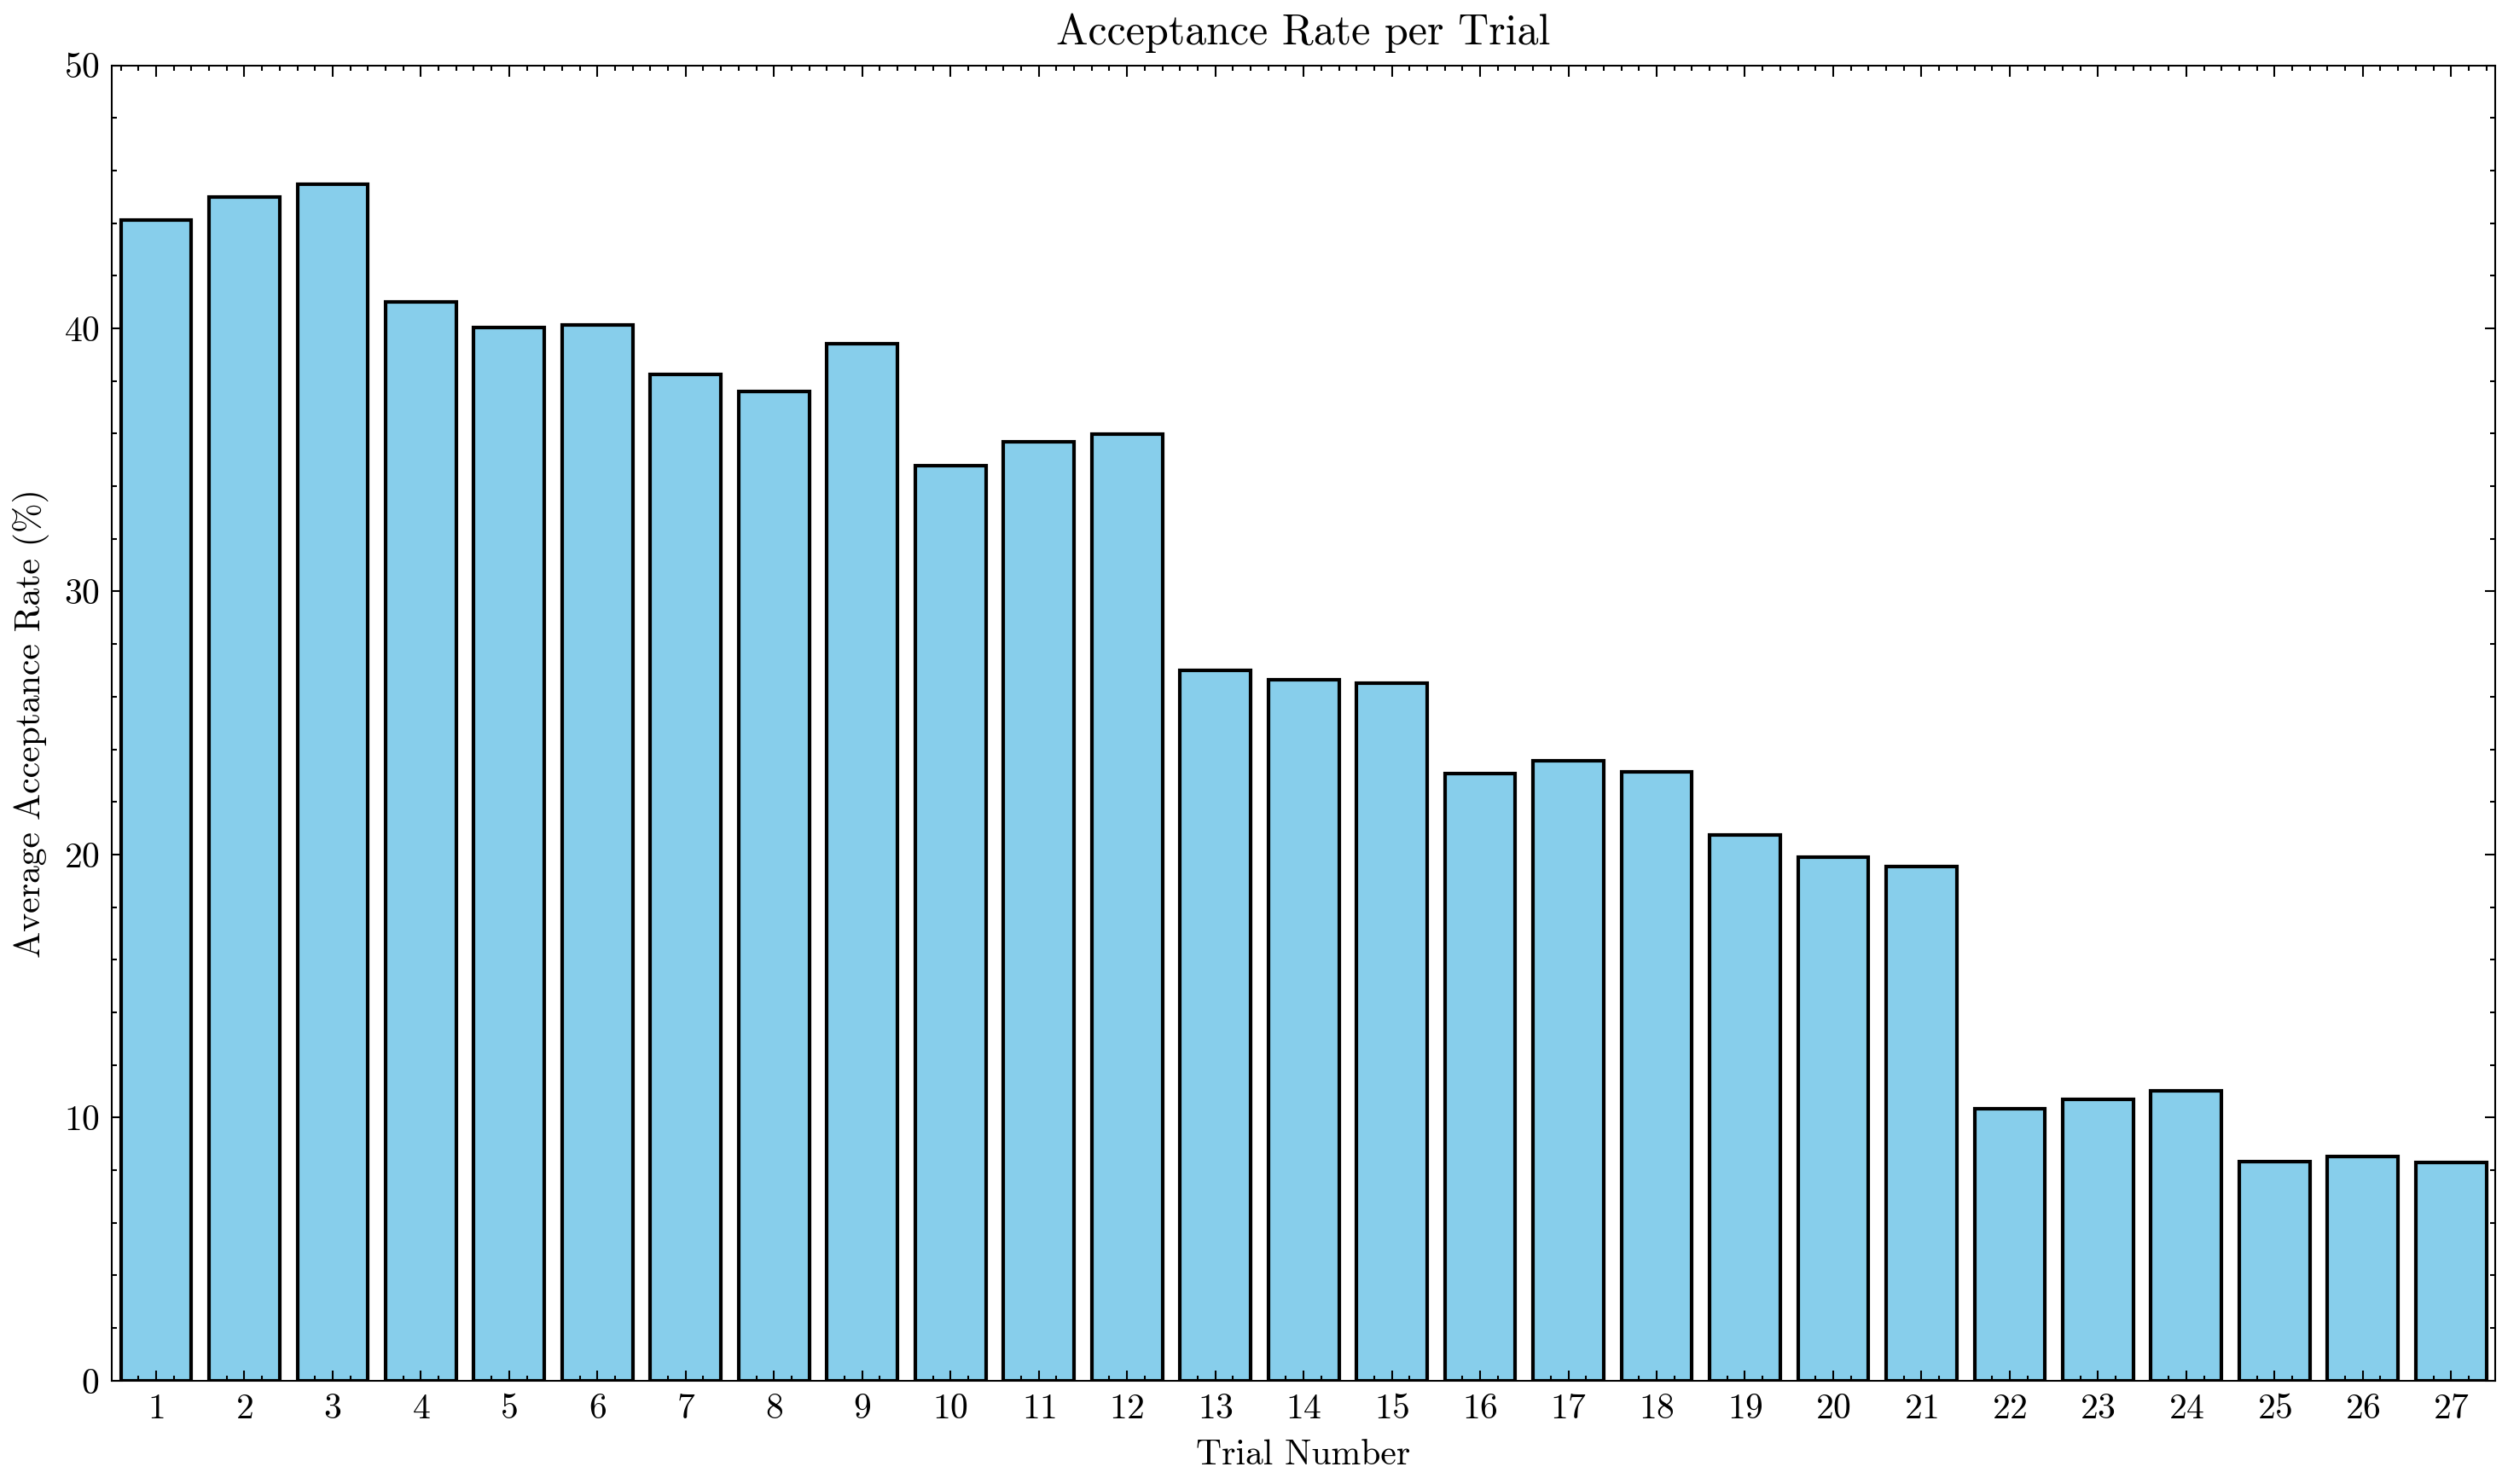

In [8]:
import scienceplots


#append df to have number of the trial to keep track
results_df['trial'] = np.arange(1, len(results_df) +1)


plt.style.use(['science', 'no-latex'])

plt.figure(figsize=(10,6), dpi = 300)
plt.bar(results_df['trial'], results_df['avg_alpha']*100,
        width=0.8, color='skyblue', edgecolor='black')
plt.ylim(0,50)
plt.xlim([0.5,len(results_df)+0.5])
plt.xlabel('Trial Number')
plt.ylabel('Average Acceptance Rate (%)')
plt.title('Acceptance Rate per Trial')
plt.xticks(np.linspace(1,27,27))



plt.tight_layout()

plt.show()


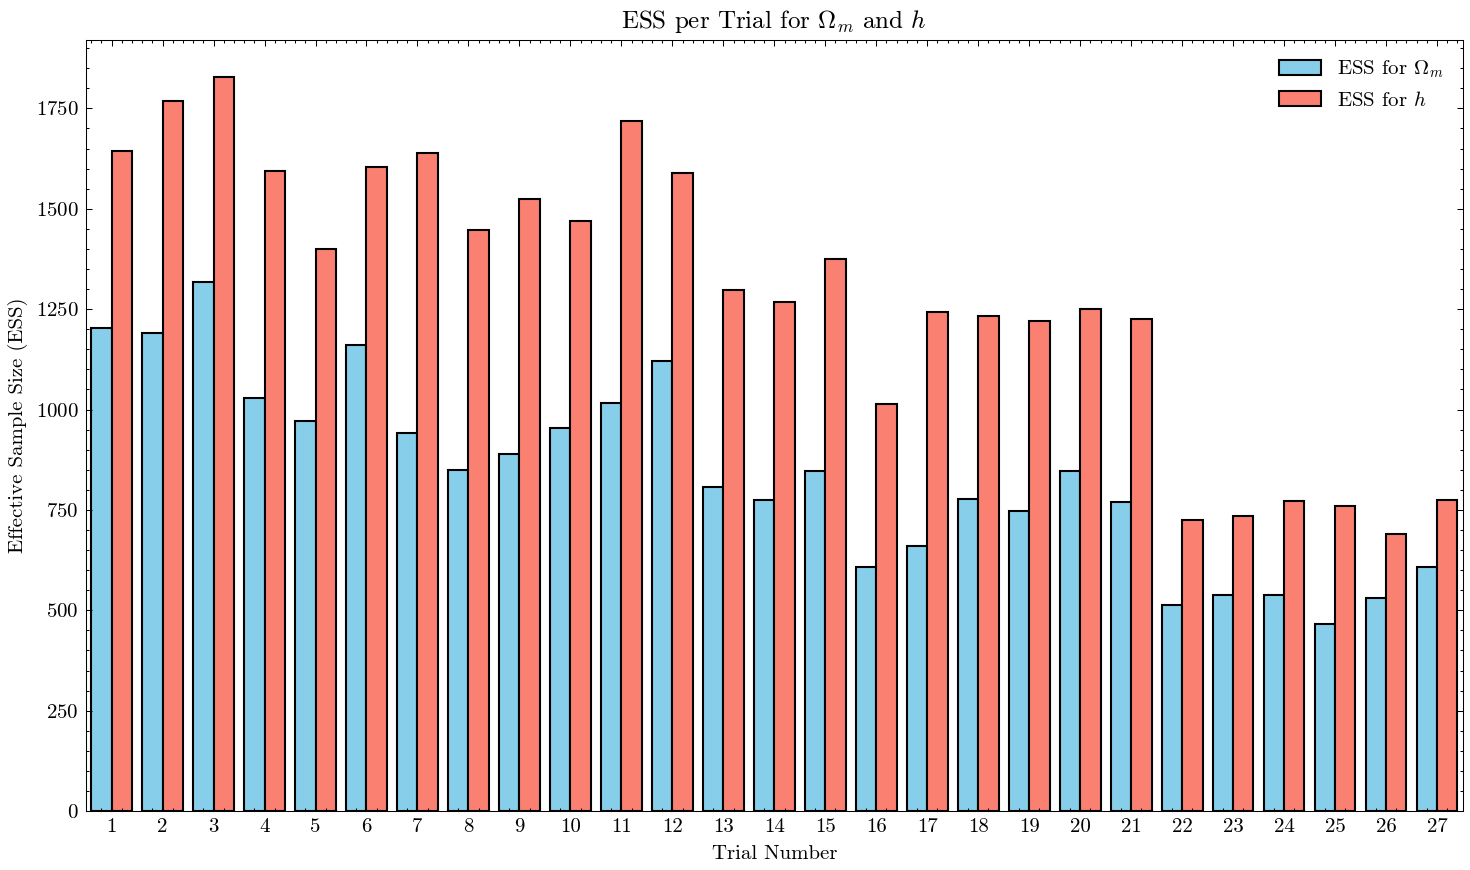

In [9]:
#plot for ess for omega m and h

plt.style.use(['science', 'no-latex'])
n_trials = len(results_df)

plt.figure(figsize=(10,6), dpi=150)

width = 0.4

# Use the trial column as the baseline x positions:
x_positions = results_df['trial']

# Plot bars for ESS of omega_m (shifted left by width/2)
plt.bar(x_positions - width/2, results_df['ess_omega'],
        width=width, color='skyblue', edgecolor='black',
        label='ESS for $\\Omega_m$')

# Plot bars for ESS of h (shifted right by width/2)
plt.bar(x_positions + width/2, results_df['ess_h'],
        width=width, color='salmon', edgecolor='black',
        label='ESS for $h$')

plt.xlim([0.5, n_trials + 0.5])


plt.xticks(x_positions, x_positions)

plt.xlabel("Trial Number")
plt.ylabel("Effective Sample Size (ESS)")
plt.title("ESS per Trial for $\\Omega_m$ and $h$")


plt.legend()

plt.tight_layout()
plt.show()


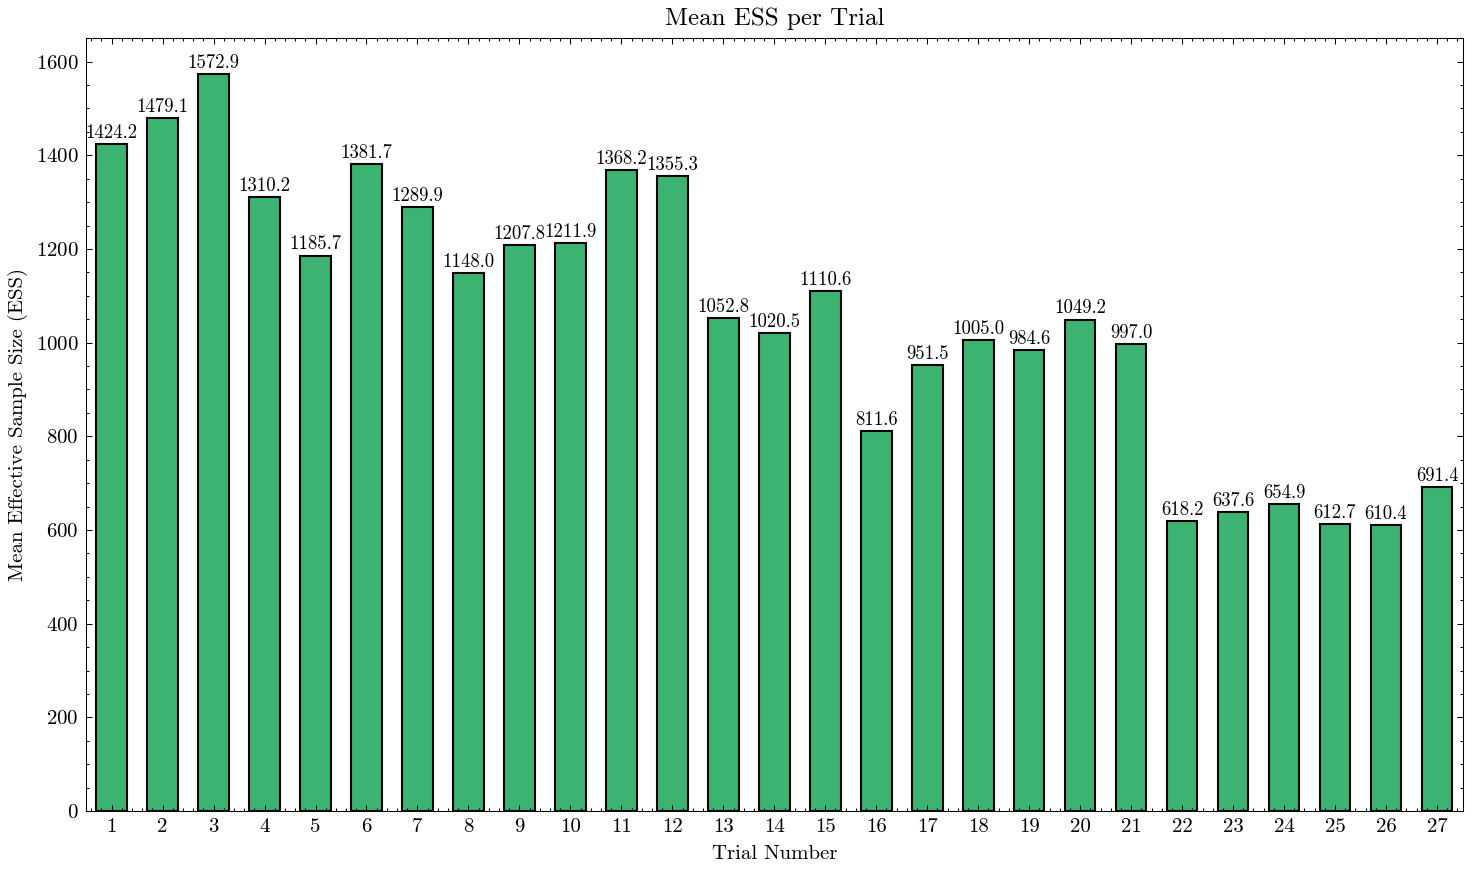

In [11]:
# Calculate mean ESS per trial (average of ESS omega_m and ESS h)
results_df['mean_ess'] = results_df[['ess_omega', 'ess_h']].mean(axis=1)

plt.figure(figsize=(10, 6), dpi=150)
width = 0.6

x_positions = results_df['trial']

# Plot mean ESS bars
plt.bar(x_positions, results_df['mean_ess'],
        width=width, color='mediumseagreen', edgecolor='black')

# Annotate bars with ESS mean values
for x, mean_ess in zip(x_positions, results_df['mean_ess']):
    plt.text(x, mean_ess + 5, f'{mean_ess:.1f}', ha='center', va='bottom', fontsize=9)

plt.xlim([0.5, len(results_df) + 0.5])
plt.xticks(x_positions, x_positions)

plt.xlabel("Trial Number")
plt.ylabel("Mean Effective Sample Size (ESS)")
plt.title("Mean ESS per Trial")

plt.tight_layout()
plt.show()


Plotting step size history of each

* Best looking Trials are: 1, 2, 3




* Make sure they converged using GR diagnostic
* Find out what they used
* Plotting the covariances and step sizes

In [13]:
#Getting stats for each
trial_1 = results_df.iloc[0]
trial_3 = results_df.iloc[1]
trial_10 = results_df.iloc[2]

for i in [0, 1, 2]:
    row = results_df.iloc[i]
    print(f"Trial {row['trial']}:")
    print(f"Step Size: {row['step_size']}")
    print(f"Update Interval: {row['update_interval']}")
    print(f"Learning Rate: {row['learning_rate']}")
    print(f"Average Acceptance Rate (avg_alpha): {row['avg_alpha']:.4f}")
    print(f"ESS for Omega_m: {row['ess_omega']:.2f}")
    print(f"ESS for h: {row['ess_h']:.2f}")


Trial 1:
Step Size: [0.01, 0.01]
Update Interval: 100
Learning Rate: 0.01
Average Acceptance Rate (avg_alpha): 0.4411
ESS for Omega_m: 1203.31
ESS for h: 1645.02
Trial 2:
Step Size: [0.01, 0.01]
Update Interval: 100
Learning Rate: 0.05
Average Acceptance Rate (avg_alpha): 0.4498
ESS for Omega_m: 1190.70
ESS for h: 1767.44
Trial 3:
Step Size: [0.01, 0.01]
Update Interval: 100
Learning Rate: 0.1
Average Acceptance Rate (avg_alpha): 0.4548
ESS for Omega_m: 1316.92
ESS for h: 1828.88


In [14]:
#Gelman rubin to check the 3 chains have converged
trial1_chain = np.array(results_df.iloc[0,0])
trial3_chain = np.array(results_df.iloc[1,0])
trial10_chain = np.array(results_df.iloc[3,0])

#loop this for the trials i want

for i in [0,2,9]:

  ith_chain = np.array(results_df.iloc[i,0])

  #pick omega and h chains
  ith_omega = ith_chain[:,:,0]
  ith_h = ith_chain[:,:,1]

  #calculate GR for omega and h
  gr_omega = gelman_rubin(ith_omega)
  gr_h = gelman_rubin(ith_h)

  print(f'For trial {i+1}: the GR values for omega = {gr_omega}, h = {gr_h}')



For trial 1: the GR values for omega = 1.0073000221960509, h = 1.0052878488131076
For trial 3: the GR values for omega = 1.012587818334849, h = 1.0094131886992488
For trial 10: the GR values for omega = 1.003071253165287, h = 1.0029426513275028


Plotting step history

In [17]:
#getting step history from the table

step_hist1 = np.array(results_df.iloc[0]['step_hist'])
step_hist2 = np.array(results_df.iloc[1]['step_hist'])
step_hist3 = np.array(results_df.iloc[2]['step_hist'])

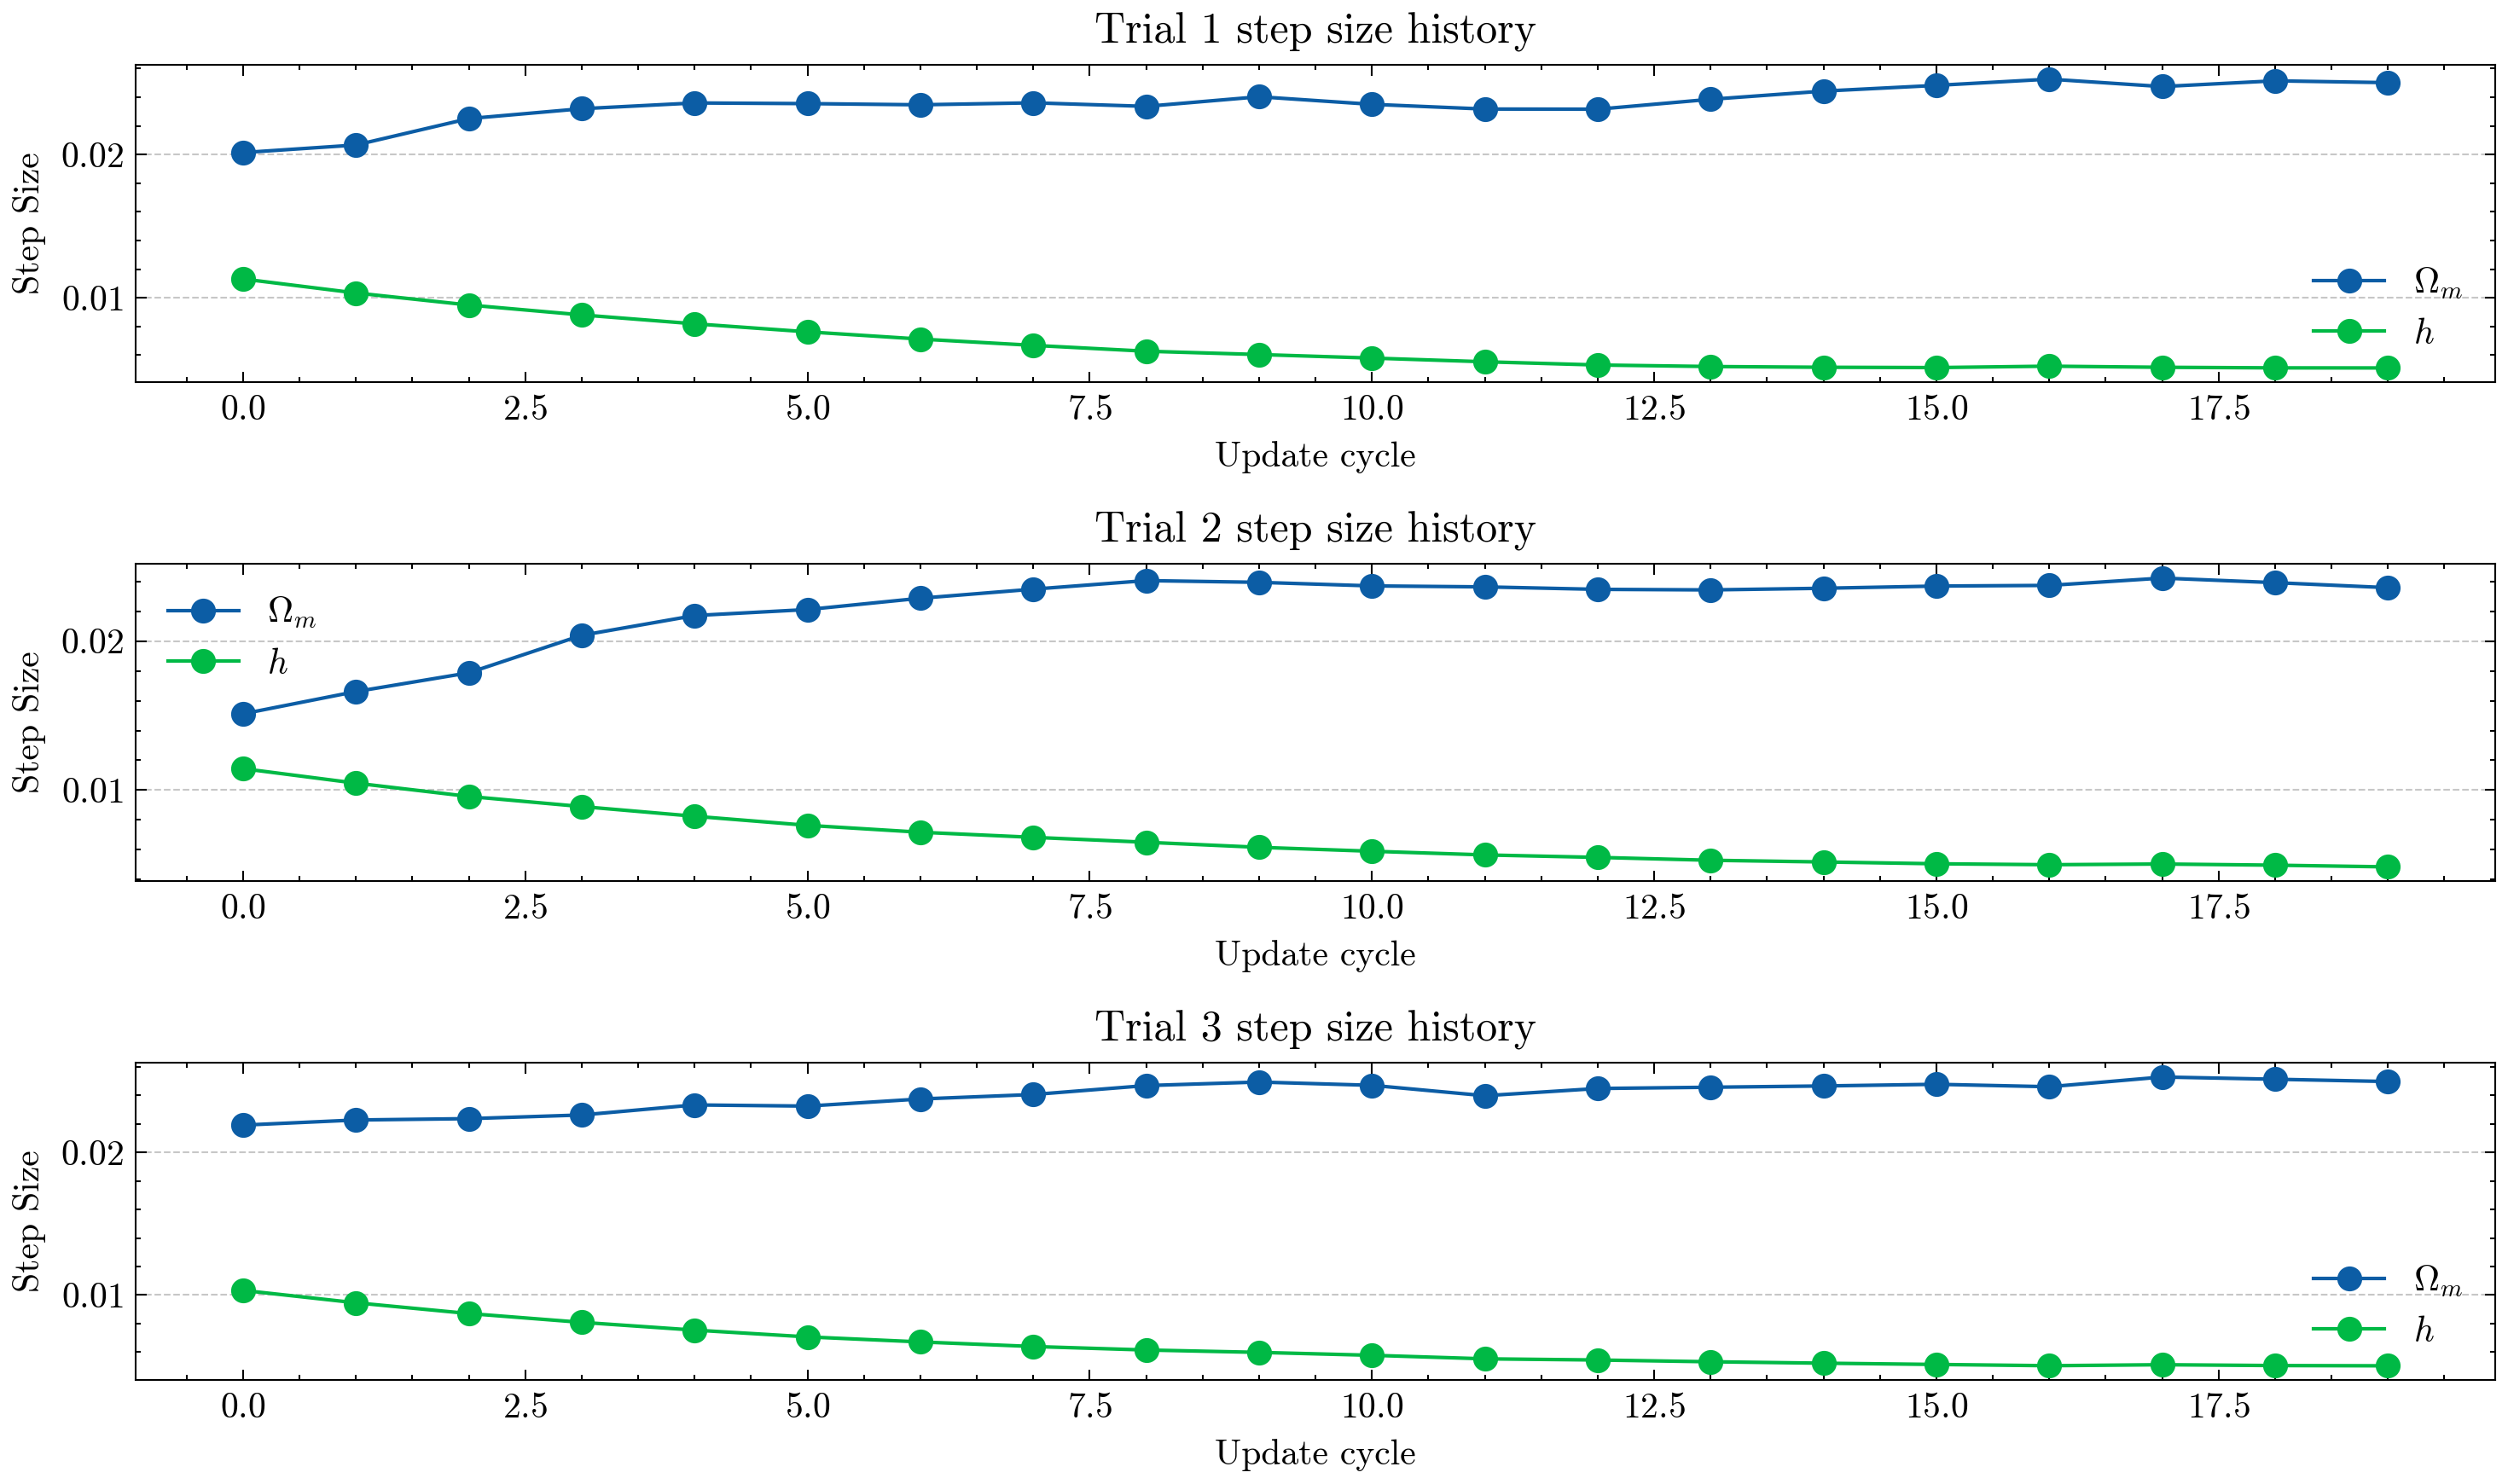

In [18]:
#subplot of all the things

plt.figure(figsize=(10,6), dpi = 300)

plt.subplot(3,1,1)
plt.plot(step_hist1[:,0], label = '$\Omega_m$', marker='o')
plt.plot(step_hist1[:,1], label = '$h$', marker='o')
plt.xlabel('Update cycle')
plt.ylabel('Step Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Trial 1 step size history')
plt.legend()

plt.subplot(3,1,2)
plt.plot(step_hist2[:,0], label = '$\Omega_m$', marker='o')
plt.plot(step_hist2[:,1], label = '$h$', marker='o')
plt.xlabel('Update cycle')
plt.ylabel('Step Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Trial 2 step size history')
plt.legend()


plt.subplot(3,1,3)
plt.plot(step_hist3[:,0], label = '$\Omega_m$', marker='o')
plt.plot(step_hist3[:,1], label = '$h$', marker='o')
plt.xlabel('Update cycle')
plt.ylabel('Step Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Trial 3 step size history')
plt.legend()

plt.tight_layout()
plt.show()

#in retrospect i shouldve for looped that mayeb

Step size history is looking normal for all so i will proceed with trial 3 paramaters of 0.01 step size, 100 update interval, 0.1 LR